# Bollywood Movie Recommender
> Applying TFIDF and Cosine similarity techniques on bollywood IMDB movie dataset to build a simple content-based recommender and wrapping into an app

- toc: true
- badges: true
- comments: true
- categories: [TFIDF, Movie, Flask, App, Heroku]
- author: "<a href='https://github.com/DipabaliHalder/Bollywood-Movie-Recommender'>Dipabali_Halder</a>"
- image:

## Setup

In [10]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import pickle

import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [11]:
df = pd.read_csv('https://github.com/sparsh-ai/Bollywood-Movie-Recommender/raw/main/model/imdb_2000bollywood_movies.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   img         2050 non-null   object
 1   movie_name  2050 non-null   object
 2   year        2050 non-null   object
 3   genre       2050 non-null   object
 4   Overview    2049 non-null   object
 5   Director    2050 non-null   object
 6   Actor1      2050 non-null   object
 7   Actor2      2050 non-null   object
 8   Actor3      2048 non-null   object
 9   Actor4      2044 non-null   object
dtypes: object(10)
memory usage: 160.3+ KB


In [12]:
df.head()

,img,movie_name,year,genre,Overview,Director,Actor1,Actor2,Actor3,Actor4
0,https://m.media-amazon.com/images/M/MV5BNTkyOG...,3 Idiots,-2009,"Comedy, Drama",Two friends are searching for their long lost ...,Rajkumar Hirani,Aamir Khan,Madhavan,Mona Singh,Sharman Joshi
1,https://m.media-amazon.com/images/M/MV5BMDhjZW...,Like Stars on Earth,-2007,"Drama, Family",An eight-year-old boy is thought to be a lazy ...,Aamir Khan,Amole Gupte,Darsheel Safary,Aamir Khan,Tisca Chopra
2,https://m.media-amazon.com/images/M/MV5BMTYzOT...,PK,-2014,"Comedy, Drama, Musical",An alien on Earth loses the only device he can...,Rajkumar Hirani,Aamir Khan,Anushka Sharma,Sanjay Dutt,Boman Irani
3,https://m.media-amazon.com/images/M/MV5BMTQ4Mz...,Dangal,-2016,"Action, Biography, Drama",Former wrestler and his two wrestler daughter...,Nitesh Tiwari,Aamir Khan,Sakshi Tanwar,Fatima Sana Shaikh,Sanya Malhotra
4,https://m.media-amazon.com/images/M/MV5BYTQxMm...,Radhe,-2021,"Action, Crime, Thriller","After taking the dreaded gangster Gani Bhai, A...",Prabhu Deva,Salman Khan,Disha Patani,Randeep Hooda,Jackie Shroff


## Data Preprocessing

In [13]:
# Combine action names to make it a string
df['Actor'] = df['Actor1']+","+df['Actor2']+","+df['Actor3']+","+df['Actor4']

# select columns of interest
movies = df[['img','movie_name','year','genre','Overview','Director','Actor']]

# remove "-" sign from movie year column
movies['year'] = movies['year'].apply(lambda x:x.replace('-',''))

# convert overview, actor and director column string values into a list
movies['Overview'] = movies['Overview'].apply(lambda x:str(x).replace(" ","  ").split())
movies['Actor'] = movies['Actor'].apply(lambda x:str(x).replace(" ","").split())
movies['Director'] = movies['Director'].apply(lambda x:x.replace(" ","").split())

# remove "," in genres
movies['genre'] = movies['genre'].apply(lambda x:x.replace(",","").split())

# combine genres, overview, actor and director columns into a single list
movies['tags'] = movies['genre']+movies['Overview']+movies['Actor']+movies['Director']

# dropping the extra columns
new = movies.drop(columns=['Overview','genre','Actor','Director','img'])

# convert list into a text string
new['tags']=new['tags'].apply(lambda x:" ".join(x))

# checking the data
new.head()

,movie_name,year,tags
0,3 Idiots,2009,Comedy Drama Two friends are searching for the...
1,Like Stars on Earth,2007,Drama Family An eight-year-old boy is thought ...
2,PK,2014,Comedy Drama Musical An alien on Earth loses t...
3,Dangal,2016,Action Biography Drama Former wrestler and his...
4,Radhe,2021,Action Crime Thriller After taking the dreaded...


## Memory-based Model

### Count Vectorizer

In [14]:
cv=CountVectorizer(max_features=10000,stop_words='english')
vector = cv.fit_transform(new['tags']).toarray()
vector[:10,:10]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

### Cosine Similarity Matrix

In [15]:
similarity=cosine_similarity(vector)
similarity[0]

array([1.        , 0.11766968, 0.15689291, ..., 0.        , 0.05547002,
       0.07698004])

## Inference

In [16]:
def recommend(movie):
  index = new[new['movie_name']== movie].index[0]        
  distances = sorted(list(enumerate(similarity[index])),reverse=True,key= lambda x: x[1])
  for i in distances[1:6]:
    movie=new.iloc[i[0]].movie_name
    print(movie)

In [17]:
recommend('3 Idiots')

Chhichhore
Dil Chahta Hai
Ta Ra Rum Pum
Rang De Basanti
Zindagi Na Milegi Dobara


In [18]:
recommend('Commando')

Commando 2
Commando 3
Baadshaho
War
Junglee


## Save the Artifacts

In [19]:
pickle.dump(new,open('finalmovie_list.pkl','wb'))
pickle.dump(similarity,open('finalsimilarity.pkl','wb'))

## API

In [ ]:
import streamlit as st
import pickle
import numpy as np
import requests
import pandas as pd

def fetch_poster(movie):
    url = "https://www.omdbapi.com/?apikey=21dcff44&t={}".format(movie)
    data = requests.get(url)
    data = data.json()
    try:
        return data['Poster']
    except:
        return ('')

def recommend(movie):
    index = movies[movies['movie_name'] == movie].index[0]
    distances = sorted(list(enumerate(similarity[index])), reverse=True, key=lambda x: x[1])
    recommended_movie_names=[]
    recommended_movie_posters=[]
    for i in distances[1:6]:
        m=movies.iloc[i[0]].movie_name
        recommended_movie_names.append(m)
        recommended_movie_posters.append(fetch_poster(m))
    return recommended_movie_names,recommended_movie_posters

st.header("**Movie Recommender System**")

movies=pd.read_pickle('finalmovie_list.pkl')
similarity= pickle.load(open('finalsimilarity.pkl','rb'))

movie_list = np.sort(movies['movie_name'].unique())
movie_list=np.insert(movie_list,0,'')
selected_movie = st.selectbox("Choose a Movie: ",movie_list)

if st.button("Recommend >>"):
    if (selected_movie ==''):
        st.subheader("*No movie selected!!! Please select a movie.*")
    else:
        recommended_movie_names,recommended_movie_posters = recommend(selected_movie)
        col1, col2, col3, col4, col5 = st.beta_columns(5)
        with col1:
            st.text(recommended_movie_names[0])
            if(recommended_movie_posters[0]!=''):
                st.image(recommended_movie_posters[0])
            else:
                st.image("https://m.media-amazon.com/images/S/sash/4FyxwxECzL-U1J8.png")
        with col2:
            st.text(recommended_movie_names[1])
            if (recommended_movie_posters[1]!= ''):
                st.image(recommended_movie_posters[1])
            else:
                st.image("https://m.media-amazon.com/images/S/sash/4FyxwxECzL-U1J8.png")
        with col3:
            st.text(recommended_movie_names[2])
            if (recommended_movie_posters[2] != ''):
                st.image(recommended_movie_posters[2])
            else:
                st.image("https://m.media-amazon.com/images/S/sash/4FyxwxECzL-U1J8.png")
        with col4:
            st.text(recommended_movie_names[3])
            if (recommended_movie_posters[3] != ''):
                st.image(recommended_movie_posters[3])
            else:
                st.image("https://m.media-amazon.com/images/S/sash/4FyxwxECzL-U1J8.png")
        with col5:
            st.text(recommended_movie_names[4])
            if (recommended_movie_posters[4] != ''):
                st.image(recommended_movie_posters[4])
            else:
                st.image("https://m.media-amazon.com/images/S/sash/4FyxwxECzL-U1J8.png")

> Note: App link - https://bollywood-movie-recommender.herokuapp.com/

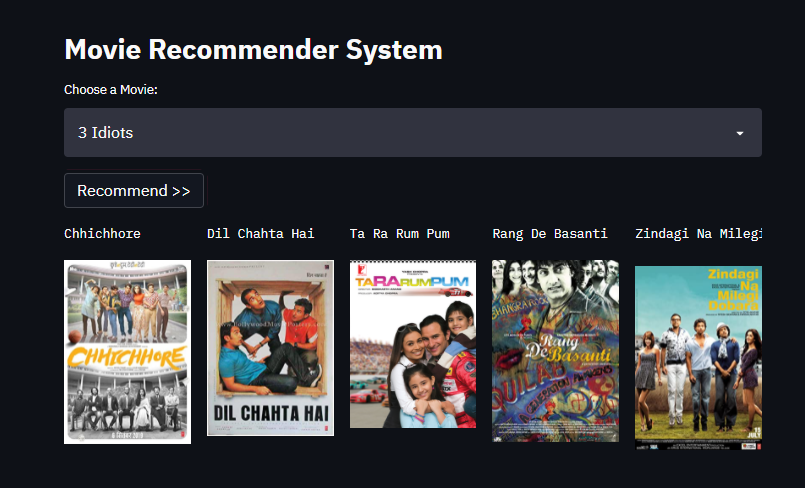